Les modèles (physiques ou corrélatifs) des pneumatiques jouent un rôle essentiel dans la mise au points de scénarios de conception ainsi que dans l'évaluation des performances des nouvelles gammes ou de gammes existantes. Ainsi, le modèle de rigidité de dérive vu dans le TP portant sur l'Optimisation Bayesienne, peut être exploité à travers des chaines de simulation pour juger de la qualité de pneumatiques en terme de critère de comportement, d'adhérence, d'endurance ou encore de temps au tour. C'est à cette performance que nous allons nous intéresser ici.

Plus précisément, l'exercice consiste à mettre en place un environnement de simulation basé sur de l'apprentissage par renforcement qui a pour objectif de trouver les controles optimaux à appliquer à un véhicule pour que ce dernier puisse parcourir un circuit circulaire avec la vitesse la plus élevée possible.

## Mise en place de l'environnement

En l'occurence, les états que l'on va considérer pour notre environnement sont:
- $x$: position du véhicule selon la direction $\vec{X}$
- $y$: position du véhicule selon la direction $\vec{Y}$
- $\psi$: l'angle de lacet du véhicule
- $\dot{x}$: vitesse du véhicule selon la direction $\vec{X}$
- $\dot{y}$: vitesse du véhicule selon la direction $\vec{Y}$
- $\dot{\psi}$: vitesse de lacet du véhicule

Les actions qui seront utilisées sont:
- $v$: la vitesse
- $\alpha$: l'angle de braquage

L'environnement que l'on va exploiter s'appuie sur le package Gym de la société OpenAI (https://gym.openai.com/). Un tel environnement s'appuie sur l'utilisation d'objets héritant de la classe *gym.Env* et comportant les méthodes suivantes:
- **__init__**: constructeur définissant les expaces d'actions (*action_space*) et d'observations (*observation_space*)
- **reset**: méthode permettant de réinitialiser les états
- **step**: fonction qui prend en entrée les valeurs des actions et renvoie les nouveaux états de l'environnement, le reward ainsi qu'un booléen indiquant s'il est nécessaire de réinitialiser les états 
- **render**: méthode qui affiche l'état de l'environnement et différentes informations le concernant 

In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib notebook

from gym_gmmcar.envs.circle_env import CircleEnv

from tensorflow.keras.layers import *
from tensorflow.keras import Model

Notre objectif étant de rester sur le cirucuit tout en allant le plus vite possible, quel(-s) reward(-s) peut-on envisager? Implémenter l'un d'entre eux en complétant la méthode *get_reward* de la classe *OttEnv* ci-dessous:

In [47]:
class OttEnv(CircleEnv):
    """
    Environnement de simulation pour une voiture de course suivant une trajectoire circulaire aussi vite que possible
    """

    def __init__(
            self,
            target_velocity=1.0,
            radius=1.0,
            dt=0.035,
            model_type='BrushTireModel',
            robot_type='RCCar',
            mu_s=1.37,
            mu_k=1.96,
            eps=0.05
    ):

        super().__init__(
            target_velocity=target_velocity,
            radius=radius,
            dt=dt,
            model_type=model_type,
            robot_type=robot_type,
            mu_s=mu_s,
            mu_k=mu_k
        )

        self.eps = eps


    def get_reward(self, state, action):
        """
        Définition de la fonction de Reward
        """
        r = self.radius
        x, y, _, x_dot, y_dot, _ = state
        vitesse = np.sqrt(x_dot**2 + y_dot**2) # à maximiser
        distance = np.sqrt(x**2 + y**2) - r # à minimiser 

        # Reward à définir
#         if distance <= 0:
#             dist_rate = self.distance_interieur_rate
#         else:
#             dist_rate = self.distance_exterieur_rate
#         reward = np.exp(self.vitesse_rate * vitesse) + np.exp( - dist_rate * abs(distance))

#         if ((abs(distance) < 0.1) and (vitesse > 4)):
#             reward = 50
#         elif (abs(distance) < 0.1) :
#             reward = 10
#         elif (vitesse > 4):
#             reward = (int(vitesse) % 10) * 10 
#         else:
#             reward = -10
        reward = 0
        if (distance == 0):
            reward += 1000
        else:
            reward -= 1000000
            
        if (vitesse < 1):
            reward -= 10000
        else:
            reward += int(vitesse) * 100
            
        
        info = {}
        info['dist'] = distance
        info['vel'] = vitesse
        info['position'] = (x,y)
        info['dot'] = (x_dot,y_dot)
        return reward, info

### Test de l'Environnement

Tester l'environnement en considérant un épisode de 100 pas de temps et des actions aléatoires et/ou fixes. Pour ce faire, compléter le script ci-dessous en définissant les actions à appliquer à chaque pas.

### Test avec un couple d'actions fixes

[ 0.04500355  0.64129124 -0.63175833  1.74283772]


<IPython.core.display.Javascript object>


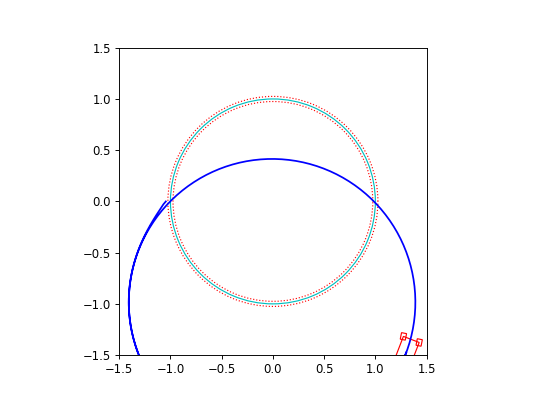

In [48]:
env = OttEnv()
obs = env.reset()
print(obs)
env.render()

etat_0, _, _, _ = env.step((0,0))
episode = 1
for step in range(200):
    action = (2, np.pi/18)
    new_state, reward, done, info = env.step(action)
    #print(info)
    #print(done)
    env.render()

### Test avec un couple d'actions aléatoires

<IPython.core.display.Javascript object>


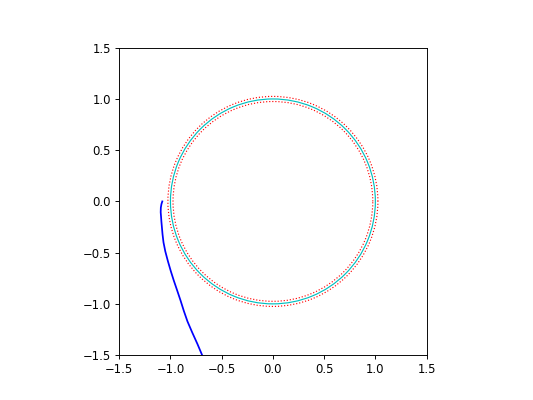

In [49]:
env = OttEnv()
obs = env.reset()
env.render()

episode = 1
for step in range(100):
    action = env.action_space.sample()
    new_state, reward, done, info = env.step(action)
    env.render()

Etant donné les caractéristiques du problème considéré, quel type de méthode devrait-on appliquer?

### On a peu d'actions discrètes donc le deep Q learning est adapté. De plus pour avoir un modèle performant, une modèle basé sur l'acteur/critique est particulièrement adapté

## Implémentation de l'Algorithme Deep Deterministic Policy Gradient (DDPG)

Pour tenter de trouver les commandes optimales à appliquer, nous allons ici utiliser une approche DDPG. Pour ce faire, la première étape à réaliser est d'implémenter cette méthode en s'appuyant sur le pseudo-code suivant vu en cours:
![DDPG.png](DDPG.png "Algorithme DDPG")

### Création de l'Acteur

Pour rappel, l'acteur a pour objectif d'estimer un politique $\mu(s_{t})$. Dans un premier temps, créer un acteur à partir d'une fonction ou d'une classe en définissant un modèle neuronal tensorflow ayant l'architecture suivante:
- une première couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
- une seconde couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
- une couche de sortie dense comportant un nombre de neurones égal au nombre d'actions et une fonction d'activation de type tanh

<ins>**Remarque:**</ins> Les sorties étant bornées entre -1 et 1, ne pas oublier de dénormaliser pour générer des valeurs d'actions conformes à l'espace des actions.
<ins>**Conseil:**</ins> Pour pouvoir tester différentes architectures par la suite, paramétrer les couches à l'aide d'une variable indiquant le nombre de neurones. 

In [58]:
# Définition de l'acteur 

def create_actor(nb_etats, nb_actions, hidden_units, upper_bound):
    
    input_etat = Input(shape=(nb_etats,))
    layer = input_etat
    for hl in hidden_units:
        layer = Dense(units=hl, activation='relu')(layer)
         
    outputs = Dense(units=nb_actions, activation='tanh', kernel_initializer =  tf.random_uniform_initializer)(layer) 
    
    outputs = outputs * upper_bound + np.array([5,0])
    
    model = Model(inputs=input_etat, outputs=outputs)
    return model

#Définition de la politique servant à être sûr qu'avec le bruit, on ne dépasse pas les bornes de l'espace de départ
def policy(acteur, etat, noise, lower_bound, upper_bound):
    actions = tf.squeeze(acteur(etat))

    # Ajout du bruit
    actions = actions.numpy() + noise

    # On s'assure d'avoir des actions compatibles avec l'espace de départ
    legal_action = np.array([])
    for action, lb, ub in zip(actions,lower_bound, upper_bound) :
        legal_action = np.append(legal_action, np.clip(action, lb, ub))

    return np.squeeze(legal_action)

# Apprentissage de l'acteur 
@tf.function
def update_actor(acteur, critique, prev_etat, actor_optimizer):
    
    with tf.GradientTape() as tape:
        #On calcule l'action en fonction de l'état précédent
        actions = acteur(prev_etat, training=True)
        
        #On calcule la valeur que retourne le critique par rapport à ces actions
        critic_value = critique([prev_etat, actions], training=True)
        
        #On veut maximiser l'espérance de gain du critique donc minimiser - espérrance
        actor_loss = -tf.math.reduce_mean(critic_value)

    #Mise en place de la rétropropagation de l'acteur
    actor_grad = tape.gradient(actor_loss, acteur.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grad, acteur.trainable_variables))

### Création du Critique

Pour rappel, le critique a pour objectif d'estimer la valeur $Q(s_{t},a_{t})$Dans un premier temps, créer un critique à partir d'une fonction ou d'une classe en définissant un modèle neuronal tensorflow de la manière suivante:
- Créer un réseau prenant en entrée les états avec:
  - une première couche cachée dense comportant 16 neurones et une fonction d'activation de type RELU
  - une seconde couche cachée dense comportant 32 neurones et une fonction d'activation de type RELU
- Créer un réseau prenant en entrée les actions avec une couche cachée dense comportant 32 neurones et une fonction d'activation de type RELU
- Concaténer les sorties des 2 réseaux précédents via la méthode "*Concatenate*"
- Créer un réseau prenant les entrées la concaténation des tenseurs précédents avec:
  - une première couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
  - une seconde couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
  - une couche de sortie dense comportant 1 neurone sans fonction d'activation 

<ins>**Conseil:**</ins> Pour pouvoir tester différentes architectures par la suite, paramétrer les couches à l'aide d'une variable indiquant le nombre de neurones. 

In [59]:
# Définition du critique

def create_critic(nb_etats, nb_actions, hidden_units_etat, hidden_units_action, hidden_units_concat):
    
    input_etat = Input(shape=(nb_etats,))
    layer1 = input_etat
    for hl in hidden_units_etat:
        layer1 = Dense(units=hl, activation='relu')(layer1)
        
    input_action = Input(shape=(nb_actions,))
    layer2 = input_action
    for hl in hidden_units_action:
        layer2 = Dense(units=hl, activation='relu')(layer2)    
    
    layer3 = Concatenate(axis=1)([layer1, layer2])   
    for hl in hidden_units_concat:
        layer3 = Dense(units=hl, activation='relu')(layer3) 
        
    outputs = Dense(units=1)(layer3) 
    
    model = Model(inputs=[input_etat, input_action], outputs=outputs)
    return model

# Apprentissage du critique 
@tf.function
def update_critique(acteur_cible, critique_cible, critique, prev_etat, action, reward, next_etat, critic_optimizer, gamma):
    
    with tf.GradientTape() as tape:
        #Prédition de l'action via l'acteur cible
        actions_cible = acteur_cible(next_etat, training=True)
        
        #Calcul de y et MSE entre y et la sortie du critique
        y = reward + gamma * critique_cible([next_etat, actions_cible], training=True)
        critic_value = critique([prev_etat, action], training=True)
        critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

    #Mise en place de la rétropropagation du critique
    critic_grad = tape.gradient(critic_loss, critique.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_grad, critique.trainable_variables))

### Création du Générateur de Bruit

Comme précisé en cours, l'approche DDPG génère les actions de manière déterministe, ce qui engendre mécaniquement une démarche purement basée sur de l'exploitation. Pour éviter d'être coincé dans un optimum local, il est nécessaire d'appliquer une stratégie d'exploration. En l'occurrence, cette exploration est gérée via l'ajout d'un bruit à l'action générée par l'acteur.
Ce bruit est généré via un processus stochastique de type ***Ornstein-Uhlenbeck*** défini par l'équation différentielle stochastique:

$dx_{t}=\theta(\nu-x_{t})dt+\sigma\sqrt{d_{t}}u$ avec $u\sim \mathcal{N}(0,1)$

Créer une fonction ou classe permettant de générer ce bruit avec $\theta=0.15$ et $d_{t}=1e-2$.

In [60]:
# Définition du générateur de bruit de type Ornstein-Uhlenbeck

class Noise():
    
    def __init__(self, nb_actions, nu , sigma, theta = 0.15, dt = 1e-2):
        self.nu = nu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        self.x = np.zeros(nb_actions)
    
    #Fonction servant à calculer le bruit suivant d'un même processus
    def next(self):
        self.x = self.x + self.theta*(self.nu - self.x)*self.dt\
                + self.sigma*np.sqrt(self.dt)*np.random.normal(0, 1, self.x.shape)
        
        return self.x

### Gestion de l'Experience Replay

Afin de ne pas oublier les expériences passées et réduire les corrélations entre expériences, un tirage aléatoire de $N$ tuples (état présent, action, reward, état suivant) stockés dans un buffer de taille $B$.
Créer une fonction ou classe permettant de:
- Initialiser un buffer de taille $B$ à 0
- Sauvegarder à chaque pas de temps un 4-uplet (état présent, action, reward, état suivant)
- Tirer aléatoirement $N$ tuples (état présent, action, reward, état suivant)

In [61]:
#### Définition du buffer servant à garder en mémoire les expériences passées

class Buffer():
    
    #Initialisation du buffer
    def __init__(self,B):
        self.capacite = B
        self.buffer = [0]*B
        self.indice = 0
    
    #Sauvergarde d'un tuple dans le buffer 
    def save(self, prev_etat, action, reward, next_etat):
        self.buffer[self.indice % self.capacite] = (prev_etat, action, reward, next_etat)
        #Si le buffer est plein, on va remplacer la plus ancienne expérience
        self.indice += 1
        
    #Tirage aléatoire d'un batch dans le buffer
    def sample(self, N):
        
        #On prend le batch de taille N ou moins suivant le pas de temps effectué
        buffer_size = min(self.indice, self.capacite)
        
        # Tirage aléatoire de N indices parmi les indices entre 0 et buffer_size
        batch_indices = np.random.choice(buffer_size, N)
        batch = [self.buffer[indice] for indice in batch_indices]
        
        return batch

#Apprentissage du batch par les réseaux
def learn_batch(acteur, critique, acteur_cible, critique_cible, buffer, N, gamma, actor_optimizer, critic_optimizer):

    
    batch = buffer.sample(N)
    
    # Convert to tensors
    prev_etat = tf.convert_to_tensor([elem[0] for elem in batch])
    action = tf.convert_to_tensor([elem[1] for elem in batch])
    reward = tf.convert_to_tensor([elem[2] for elem in batch])
    reward = tf.cast(reward, dtype=tf.float32)
    next_etat = tf.convert_to_tensor([elem[3] for elem in batch])

    update_actor(acteur, critique, prev_etat, actor_optimizer)
    update_critique(acteur_cible, critique_cible, critique, prev_etat, action, reward, next_etat, critic_optimizer, gamma)

### Mise à jour des réseaux cibles

Comme présenté en cours, la gestion des cibles mouvantes se fait via la mise en place de réseaux cibles. En l'occurrence, deux réseaux cibles sont utilisés: l'un pour l'acteur et l'autre pour le critique.
Créer une fonction ou classe qui mette à jour les poids des réseaux cibles.

In [62]:
# Mise à jour des réseaux cibles
@tf.function
def maj_cible(cible, reseau, tau):
    
    for (cible_poids, reseau_poids) in zip(cible.variables, reseau.variables):
        cible_poids.assign(reseau_poids * tau + cible_poids * (1 - tau))

### Apprentissage

Utiliser l'ensembles des fonctions/classes précédemment construites pour implémenter l'apprentissage présenté par le pseudo-code apparaissant plus haut avec les paramètres suivants:
- learning rate de l'acteur:0.002
- learning rate du critique: 0.001
- paramètre du générateur de bruit $\sigma$: 0.2
- paramètre du générateur de bruit $\nu$: 0
- nombre totale d'épisode $M$: 100
- facteur d'escompte $\gamma$: 0.99
- paramètre mise à jour des réseaux cible $\tau$: 0.005
- taille du buffer $B$: 1000
- taille $N$ des batchs: 100

Pour pouvoir mener un diagnosqtique de l'apprentissage, stocker les rewards cumulés à la fin de chaque épisode dans une liste.

In [63]:
env = OttEnv()
env.reset()

nb_etats = 6 #env.observation_space.shape[0]
print("Dimension de l'espace d'états {}".format(nb_etats))
nb_actions = env.action_space.shape[0]
print("Dimension de l'espace d'actions {}".format(nb_actions))

upper_bound = env.action_space.high
lower_bound = env.action_space.low

print("Borne supérieure des actions ->  {}".format(upper_bound))
print("Borne inférieur des actions ->  {}".format(lower_bound))


Dimension de l'espace d'états 6
Dimension de l'espace d'actions 2
Borne supérieure des actions ->  [10.         0.5235988]
Borne inférieur des actions ->  [ 0.        -0.5235988]


In [64]:
#Utilisation d'une autre borne pour la vitesse au sein de l'acteur
upper_bound2 = np.copy(upper_bound)
upper_bound2[0] = 5

### On cherche une fonction dont la distance tend vers la valeur 0 et la vitesse tend vers +inf

In [65]:
distance = np.linspace(-0.5, 0.5, 10)
vitesse = np.linspace(0, 10, 10)

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [67]:
def func_reward(x, y):
    return x + np.exp(x - 5*abs(y))

<IPython.core.display.Javascript object>


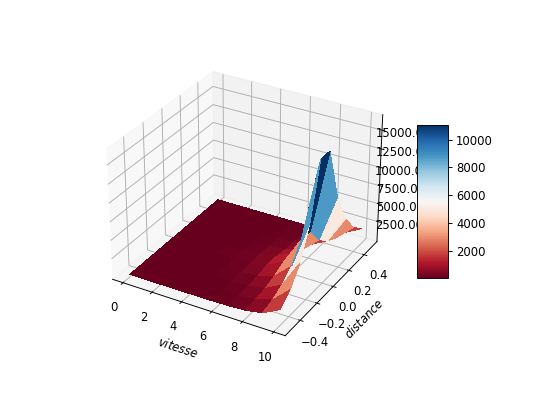

In [68]:
X,Y = np.meshgrid(vitesse, distance) # grid of point
Z = func_reward(X, Y) # evaluation of the function on the grid

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('$vitesse$')
ax.set_ylabel('$distance$')


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Implémentation de la fonction principale

In [70]:
def DDPG(actor_lr = 0.002, critic_lr = 0.001, noise_sigma = 0.2, noise_mu = 0, M = 100, gamma = 0.99, tau = 0.005, B = 1000, N = 100):

    #Création des réseaux

    actor_model = create_actor(nb_etats, nb_actions, (256,256), upper_bound2)
    critic_model = create_critic(nb_etats, nb_actions, (16,32), (32,), (256,256))


    target_actor = create_actor(nb_etats, nb_actions, (256,256), upper_bound2)
    target_critic = create_critic(nb_etats, nb_actions, (16,32), (32,), (256,256))

    # On fait en sorte que les réseaux cibles soit les mêmes que les réseaux à l'initialisation
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

    #Utilisation d'Adamax pour l'optimisation
    critic_optimizer = tf.keras.optimizers.Adamax(critic_lr)
    actor_optimizer = tf.keras.optimizers.Adamax(actor_lr)

    # Création d'une liste permettant la sauvergarde des rewards cumulés au sein d'un épisode
    ep_reward_list = []
    
    # Création d'une liste permettant la sauvergarde des moyennes des rewards cumulés parmi les 20 derniers épisodes
    avg_reward_list = []
    
    #Définition de l'environnement
    env = OttEnv()

    #Création du buffer
    buffer = Buffer(B)
    
    for ep in range(M):

        #Génération du bruit
        noise = Noise(2, noise_mu, noise_sigma)

        #Réinitialisation de l'environnement
        env.reset()
        prev_state,_,_,_ = env.step((0,0))
        episodic_reward = 0

        while True:

            #Conservation de l'état précédent
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            #Mise en place de l'action
            action = policy(actor_model, tf_prev_state, noise.next(), lower_bound, upper_bound)
            
            #Avancement de la voiture
            state, reward, done, info = env.step(action)

            #Sauvegarde de l'action et des informations associées
            buffer.save(prev_state, action, reward, state)
            
            #Sauvergarde du reward
            episodic_reward += reward
            
            #Apprentissage des réseaux sur un batch plus petit
            learn_batch(actor_model, critic_model, target_actor, target_critic, buffer, N, gamma, actor_optimizer, critic_optimizer)

            #MAJ des réseaux
            maj_cible(target_actor, actor_model, tau)
            maj_cible(target_critic, critic_model, tau)

            # Fin de l'épisode quand done est à True
            if done:
                break

            prev_state = state

        ep_reward_list.append(episodic_reward)

        # Moyenne des rewards cumulées sur les 20 dernières expériences
        avg_reward = np.mean(ep_reward_list[-20:])
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        avg_reward_list.append(avg_reward)
    return target_actor, target_critic, avg_reward_list

### Entrainement des modèles

In [71]:
target_actor, target_critic, avg_reward_list = DDPG()

Episode * 0 * Avg Reward is ==> -99857900.0
Episode * 1 * Avg Reward is ==> -99923950.0
Episode * 2 * Avg Reward is ==> -99945966.66666667
Episode * 3 * Avg Reward is ==> -99956975.0
Episode * 4 * Avg Reward is ==> -99963580.0
Episode * 5 * Avg Reward is ==> -99966300.0
Episode * 6 * Avg Reward is ==> -99969685.71428572
Episode * 7 * Avg Reward is ==> -99972225.0
Episode * 8 * Avg Reward is ==> -99974200.0
Episode * 9 * Avg Reward is ==> -99975780.0
Episode * 10 * Avg Reward is ==> -99976154.54545455
Episode * 11 * Avg Reward is ==> -99977308.33333333
Episode * 12 * Avg Reward is ==> -99978284.61538461
Episode * 13 * Avg Reward is ==> -99979121.42857143
Episode * 14 * Avg Reward is ==> -99979846.66666667
Episode * 15 * Avg Reward is ==> -99980481.25
Episode * 16 * Avg Reward is ==> -99981041.1764706
Episode * 17 * Avg Reward is ==> -99980416.66666667
Episode * 18 * Avg Reward is ==> -99979857.89473684
Episode * 19 * Avg Reward is ==> -99980365.0
Episode * 20 * Avg Reward is ==> -999864

### Affichage de la trajectoire sur une expérience nouvelle

<IPython.core.display.Javascript object>


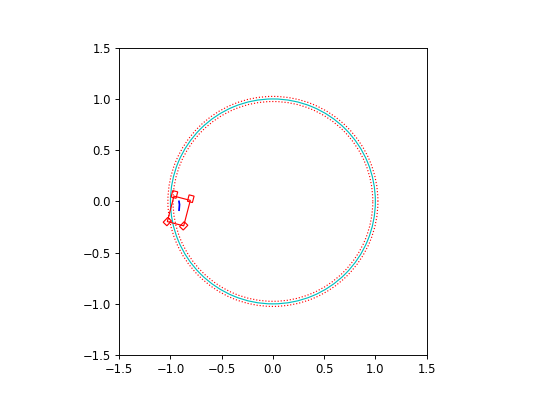

In [73]:
env = OttEnv()
obs = env.reset()
env.render()

etat, _, _, _ = env.step((0,0))
etat = etat.reshape(1, -1)
for step in range(200):
    action = target_actor.predict(etat)[0]
    etat, reward, done, info = env.step(action)
    etat = etat.reshape(1, -1)
    env.render()

### Diagnostique

Afficher l'évolution de la moyenne des rewards cumulés calculée tous les 20 épisodes.

<IPython.core.display.Javascript object>


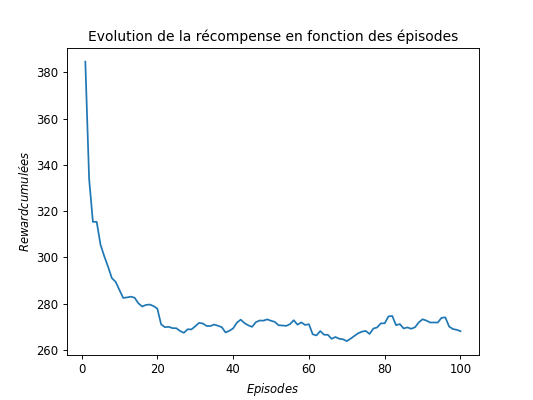

In [41]:
fig = plt.figure()
ax = plt.axes()
surf = ax.plot(np.linspace(1,100,100),avg_reward_list)

ax.set_xlabel('$Episodes$')
ax.set_ylabel('$Reward cumulées$')
ax.set_title('Evolution de la récompense en fonction des épisodes')

plt.show()

In [36]:
target_critic.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 16)           112         input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 32)           544         dense_12[0][0]                   
_______________________________________________________________________________________